In [1]:
import io 
import numpy as np
import matplotlib.pyplot as plt
import torch
import librosa
import librosa.display
import soundfile as sf
import pickle

from tifresi.utils import load_signal
from tifresi.utils import preprocess_signal
from tifresi.stft import GaussTF, GaussTruncTF
from tifresi.transforms import log_spectrogram
from tifresi.transforms import inv_log_spectrogram


np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from IPython.display import Audio 
import IPython

import sys  
sys.path.insert(0, '../')
import dnnlib

%load_ext autoreload
%autoreload 2

In [6]:
def pghi_istft(x, use_truncated_window=True):
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)

    x = np.squeeze(x,axis=0)
    new_Y = inv_log_spectrogram(x)
    new_y = stft_system.invert_spectrogram(new_Y)
    return new_y

In [2]:
network_pkl = '../training-runs/vis-data-256-split/00000/network-snapshot-002800.pkl'

stft_channels = 512
n_frames = 256
hop_size = 128
sample_rate = 16000
        
device = torch.device('cuda')

with open(network_pkl, 'rb') as pklfile:
    network = pickle.load(pklfile)
    G = network['G'].to(device).eval()
    G_ema = network['G_ema'].to(device).eval()

print(G)

Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConn

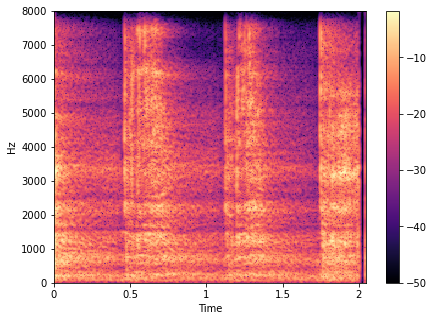

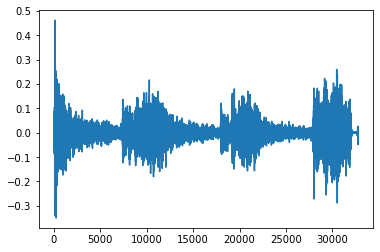

In [61]:
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
label = torch.zeros([1, G.z_dim], device=device)
img = G(z, label)


img = (img  * 127.5+ 128).clamp(0, 255).to(torch.uint8)
img = img.detach().cpu().numpy()[0]

filler = np.full((1, 1, img[0][0].shape[0]), np.min(img))
img_1 = np.append(img, filler, axis=1) # UNDOING THAT CODE!
img_1 = img_1/255
img_1 = -50+img_1*50

fig =plt.figure(figsize=(7, 5))
a=librosa.display.specshow(img_1[0],x_axis='time', y_axis='linear', hop_length=hop_size, sr=sample_rate)
fig.colorbar(a)


#Using PGHI
audio = pghi_istft(img_1)
fig = plt.figure()
plt.plot(audio)
IPython.display.display(IPython.display.Audio(audio, rate=sample_rate))


# What does the Average Style look like?

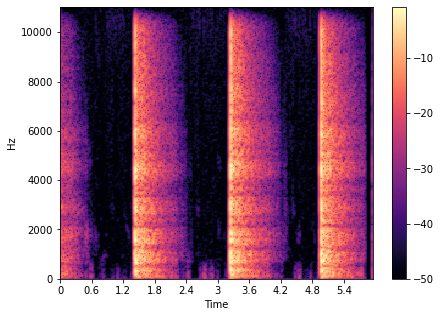

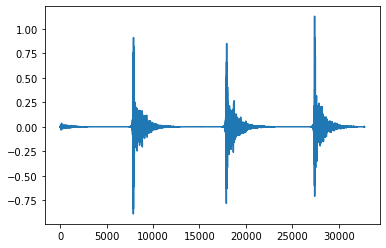

In [23]:
w_avg = G.mapping.w_avg
w =  w_avg.repeat(1, 14, 1) #+ (w - w_avg) *0.7 #truncation_psi
img = G.synthesis(w, noise_mode='const')
img = (img  * 127.5+ 128).clamp(0, 255).to(torch.uint8)
img = img.detach().cpu().numpy()[0]

filler = np.full((1, 1, img[0][0].shape[0]), np.min(img))
img_1 = np.append(img, filler, axis=1) # UNDOING THAT CODE!
img_1 = img_1/255
img_1 = -50+img_1*50

fig =plt.figure(figsize=(7, 5))
a=librosa.display.specshow(img_1[0],x_axis='time', y_axis='linear')
fig.colorbar(a)

audio = pghi_istft(img_1)
fig = plt.figure()
plt.plot(audio)
IPython.display.display(IPython.display.Audio(audio, rate=sample_rate))